Volitility Simle Curve 

Representation of the implied volatility of options across different strike prices.  Its U-shape or smile-like appearance due to typically implied volatility is higher for deep out-of-the-money (OTM) and deep in-the-money (ITM) compared to at-the-money (ATM)

OTM options have no intrinsic value, only have time value
ITM options have intrinsic value, but still can loss money if intrinsic value less than premium paid

Interpreting the Smile Curve
ATM options: Have the lowest IV (most liquid, least uncertain).
OTM/ITM options: Have higher IV due to:
Crash risk hedging (puts)
Speculative demand (calls)
Market maker adjustments for risk
Skew Effect: In equity markets, the curve often tilts to the downside (more IV for OTM puts vs. calls), forming a volatility skew.

Causing:
    
    Deep OTM: Higher IV due to demand for hedging / speculation, risk adjustments and crash protection
    Deep ITM: Higher IV due to low liquidity, difficulty in hedging and market maker adjustments
    ATM options: Generally have the lowest IV because they are the most liquid and predictable 

    Demand & Hedging Effects (Skew Effect)
        Deep OTM Puts (High IV): Traders and institutions often buy deep OTM put options as insurance (hedging against market crashes). This increased demand pushes up their implied volatility.  When market crash, traders at least can sell at the option strike price in case market price decreased to a lower price
        A put option gives the holder the right to sell an asset at a specified strike price before expiration.
        A deep OTM put has a strike price far below the current market price of the underlying asset.
        It is cheap because the probability of it expiring in the money (ITM) is low under normal conditions.
        Example:
        Suppose the S&P 500 (SPX) is at 4,800.
        A deep OTM put might have a strike price of 3,500, far below the current price.
        Deep OTM puts are an effective and low-cost hedge against market crashes, offering large asymmetric payoffs in tail-risk events. However, they require careful risk management due to time decay and premium costs.
        
        Deep OTM Calls (High IV in Some Cases)：In certain cases (e.g. meme stocks, commodities or crypto markets), deep OTM calls see high demand due to speculative buying, leading to a rise in IV

        Deep ITM Options (Less Liquidity - Higher IV): ITM options have fewer market participants and less trading volume, making their IV money sensitive to price changes

    Volatility Smile (Higher IV at Extremes)
        Implied volatility tends to be lowest for at-the-money (ATM) options and increase for deep ITM and OTM options, forming a "smile" shape on the IV curve
        This happens because deep OTM options are highly sensitive to sudden large price moves (tail risk), while deep ITM options suffer from illiquidity and wide bid-ask spreads

    Market Maker Risk & Liquidity Premium
        Market makers adjust IV to manage risk. Since deep OTM and deep ITM options are harder to hedge (due to extreme delta values and gamma risks), market makers quote higher IV to compensate for potential losses.
        
        Lower liquidity leads to wider bid-ask spreads, which artificially increase IV.

    Black-Scholes Model Limitations
        Traditional Black-Scholes models assume constant volatility, but real-world markets experience volatility clustering (where extreme price moves happen more often than a normal distribution predicts).

        To correct for this, traders apply higher IV to deep OTM and ITM options, accounting for the chance of large unexpected moves


S: Underlying Asset Spot Price
K: Strike Price
T: Time to Expiry (Time to expiration in years)
r: Risk-Free Interest Rate
IV: Implied Volatility
Call & Put: Option Type

Implied Volatility   
    
    """Calculate Black-Scholes option price."""
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == "call":
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:  # Put option
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

    When interest rate increase 
        call option price increase which means less IV is needed to match the market price -> IV slightly decrease
        put option price decrease which meams more IV is needed -> IV slightly increase


In [52]:
import yfinance as yf
from py_vollib.black_scholes.implied_volatility import implied_volatility

ticker = "SPY"

# Download option chain
stock = yf.Ticker(ticker)
S = stock.history(period='1d')['Close'].iloc[-1] # Get latest underlying asset price

In [66]:
from datetime import datetime
import numpy as np

expire_date = stock.options[10] # Chose the 10th nearest expired option
expiry_datetime = datetime.strptime(expire_date, '%Y-%m-%d')
today_date = datetime.today()
T = (expiry_datetime - today_date).days / 365 # time to expire 

r = yf.Ticker("^IRX").history(period="1d")["Close"].iloc[-1] / 100  # 13-week T-bill rate

option_chain = stock.option_chain(expire_date) # The options have the same expire date and different strike prices
calls = option_chain.calls
puts = option_chain.puts

calc_call_iv_list = []
calc_put_iv_list = []

# We should calculate implied vol for Call options and Put options separately 
    # Market Conditions affect Calls and Puts Differently
        # The imbalance between supply and demand can lead the implied volatilities of calls and puts at the same strike can be different
        # Especially when there is skew, where downside puts (strike price is lower than current stock price) often have higher IV than upside calls (strike price higher than current stock price). Due to stock tend to fall faster than they rise.  Therefore, less demand for upside calls.

    # Bid-Ask Spreads and Liquidity Differences
        # Market makers price calls and puts independently based on flow and liquidity
        # Bid-ask spread affects market price input use midpoint (bid+ask)/2 for better accuracy

for K, option_price in zip(calls['strike'], (calls['bid'] + calls['ask']) / 2):
    try:
        iv = implied_volatility(option_price, S, K, T, r, 'c')
        calc_call_iv_list.append(iv)
    except:
        calc_call_iv_list.append(0)

for K, option_price in zip(puts['strike'], (puts['bid'] + puts['ask']) / 2):
    try:
        iv = implied_volatility(option_price, S, K, T, r, 'p')
        calc_put_iv_list.append(iv)
    except:
        calc_put_iv_list.append(0)

strikes = np.concatenate([calls['strike'], puts['strike']])
calc_iv = np.concatenate([calc_call_iv_list, calc_put_iv_list])
yf_iv = np.concatenate([calls['impliedVolatility'].fillna(0), puts['impliedVolatility'].fillna(0)])

# Sort by strike price
sorted_indices = np.argsort(strikes)
strikes = strikes[sorted_indices]
calc_iv = calc_iv[sorted_indices]
yf_iv = yf_iv[sorted_indices]

Methods to Smooth IV Smile Curve

1. Polynomial Regression (Least Squares Fitting) – Fit a quadratic or cubic polynomial to the implied volatility data.
2. Gaussian Process Regression (GPR) – A machine learning approach to model IV more smoothly.
3. Spline Interpolation (Cubic Splines) – A non-parametric approach that fits smooth curves through the data.
4. Kernel Smoothing (Moving Average or Lowess) – A simple way to smooth local fluctuations.

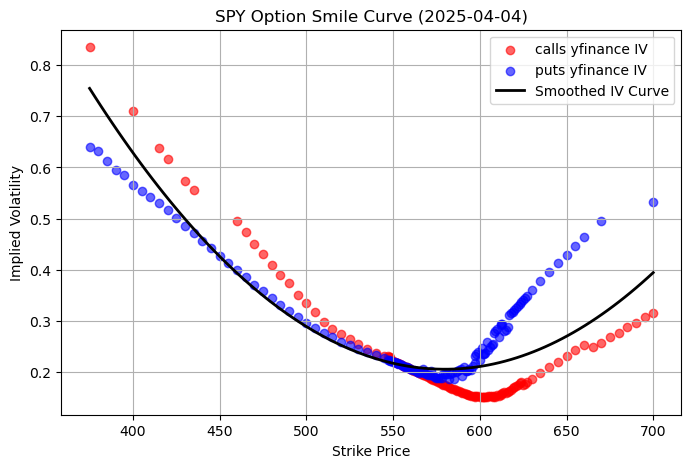

In [ ]:
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

# Define a smoothing function (quadratic fit)
def quadratic(x, a, b, c):
    return a * x**2 + b * x + c

# params, _ = curve_fit(quadratic, strikes, calc_iv)
params, _ = curve_fit(quadratic, strikes, yf_iv)
smooth_strikes = np.linspace(min(strikes), max(strikes), 100)
smooth_iv = quadratic(smooth_strikes, *params)

# Plot IV Smile Curve
plt.figure(figsize=(8, 5))
# plt.scatter(calls['strike'], calc_call_iv_list, color="blue", label="Calls IV", alpha=0.6)
# plt.scatter(puts['strike'], calc_put_iv_list, color="red", label="Puts IV", alpha=0.6)
plt.scatter(calls['strike'], calls['impliedVolatility'], color='red', label='calls yfinance IV', alpha=0.6)
plt.scatter(puts['strike'], puts['impliedVolatility'], color='blue', label='puts yfinance IV', alpha=0.6)

plt.plot(smooth_strikes, smooth_iv, color="black", label="Smoothed IV Curve", linewidth=2)
plt.xlabel("Strike Price")
plt.ylabel("Implied Volatility")
plt.title(f"{ticker} Option Smile Curve ({expire_date})")
plt.legend()
plt.grid()
plt.show()